<a href="https://colab.research.google.com/github/ProbablyBenjamin/COMP579A1/blob/main/COMP579A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COMP 579 Assignment 2 Q1**


---


The purpose of this experiment is to compare the SARSA and Expected SARSA reinforcement learning algorithms on the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) benchmark RL task. In this experiment, the default 4x4 Frozen lake map is used, with the "slippery" flag enabled, meaning that the algorithm's intended action will only be followed 1/3 of the time. Both Algorithms will run for 500 segments. A segment is defined as 10 in-game training episodes using an exploration (soft-max) policy, and one test episode using a greedy policy selecting the estimated highest-return action for each state. The last training and testing runs are then analysed (and averaged) over 10 independent trials, and the algorithms' average returns are plotted as a function of various hyper-parameters.

[Note that entire notebook takes roughly 2 hours to run]

**Import Statements**

---



In [ ]:
!pip install gymnasium


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym


**SARSA and Expected SARSA Classes**

---


In [ ]:
#Code Written by Benjamin Lo, ID: 260907455

class SARSA:

  def __init__(self, learning_rate, gamma, temperature, environment):
    self.learning_rate=learning_rate
    self.temperature=temperature
    self.environment = environment
    self.gamma = gamma
    self.q_table = np.zeros((environment.observation_space.n, environment.action_space.n))
    
  def choose_from_softmax_policy(self, state):
    softmax_prob_array = [];
    prob_sum = 0;
    #get probabilities for each action
    for i in range(self.q_table[state,:].size):
      prob_sum += np.exp(self.q_table[state,i]/self.temperature)

    for i in range(self.q_table[state,:].size):
      #boltzmann equation
      probability = np.exp(self.q_table[state,i]/self.temperature)/prob_sum
      if(np.isnan(probability)):
        #if the probability is NaN, this means that the denominator is infinite, and so numerator must also be inf
        #so replace with probability = 1
        probability = 1.0
      #print(softmax_prob_array)
      softmax_prob_array.append(probability); #stores probability of action i at index i. 
    return np.random.choice(self.environment.action_space.n, p=softmax_prob_array)

  def choose_from_optimal_policy(self,state):
    return np.argmax(self.q_table[state,:])

  def learn(self, state, action, reward, state2, action2):
    #SARSA update equation
    approximate_value = reward + self.gamma * self.q_table[state2, action2] # R*gamma*Q(s',a')
    difference = self.learning_rate*(approximate_value - self.q_table[state,action])
    self.q_table[state,action] += difference



  def run_segment(self):

    return_after_episode = 0
    episode_length = 0
    mean_training_return = 0
    test_return = 0

    for episode in range(10): #run 10 episodes with softmax

    #run once to initialize
      state1, info = self.environment.reset();
      action1 = self.choose_from_softmax_policy(state1)
      state2, reward, terminated, truncated, info = self.environment.step(action1)
      action2 = self.choose_from_softmax_policy(state2)

      self.learn(state1,action1,reward,state2,action2)
      state1 = state2
      action1 = action2

      #compute return for 1 episode step
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1


      #continue until end of episode
      while(not terminated and not truncated): 

        state2, reward, terminated, truncated, info = self.environment.step(action1)
        action2 = self.choose_from_softmax_policy(state2)
        self.learn(state1,action1,reward,state2,action2)
        state1 = state2
        action1 = action2
      
        #compute return for remaining episode steps
        return_after_episode += reward*pow(self.gamma,episode_length)
        episode_length += 1
      mean_training_return += return_after_episode #sum all returns for 10 episodes
      episode_length = 0
      return_after_episode = 0
    
    mean_training_return /= 10 #average the training returns 
    


    #Run one episode with greedy policy - no learning, just testing
    state1, info = self.environment.reset();
    action1 = self.choose_from_optimal_policy(state1)
    state2, reward, terminated, truncated, info = self.environment.step(action1)
    action2 = self.choose_from_optimal_policy(state2)

    #self.learn(state1,action1,reward,state2,action2)

    state1 = state2
    action1 = action2

    #compute return for 1 episode step
    return_after_episode += reward*pow(self.gamma,episode_length)
    episode_length += 1

    while(not terminated and not truncated): #continue until end of episode
      state2, reward, terminated, truncated, info = self.environment.step(action1)
      action2 = self.choose_from_optimal_policy(state2)
      #self.learn(state1,action1,reward,state2,action2)
      state1 = state2
      action1 = action2

      #compute return for remaining episode steps
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1
    
    test_return = return_after_episode
    
    return mean_training_return, test_return





In [ ]:
class ExpectedSARSA:

  def __init__(self, learning_rate, gamma, temperature, environment):
    self.learning_rate=learning_rate
    self.temperature=temperature
    self.environment = environment
    self.gamma = gamma
    self.q_table = np.zeros((environment.observation_space.n, environment.action_space.n))
    
  def choose_from_softmax_policy(self, state):
    softmax_prob_array = [];
    prob_sum = 0;
    #get probabilities for each action
    for i in range(self.q_table[state,:].size):
      prob_sum += np.exp(self.q_table[state,i]/self.temperature)

    for i in range(self.q_table[state,:].size):
      #boltzmann equation
      probability = np.exp(self.q_table[state,i]/self.temperature)/prob_sum
      if(np.isnan(probability)):
        #if the probability is NaN, this means that the denominator is infinite, and so numerator must also be inf
        #so replace with probability = 1
        probability = 1.0
      #print(softmax_prob_array)
      softmax_prob_array.append(probability); #stores probability of action i at index i. 
    return np.random.choice(self.environment.action_space.n, p=softmax_prob_array), softmax_prob_array

  def choose_from_optimal_policy(self,state):
    return np.argmax(self.q_table[state,:])

  def learn(self, state, action, reward, state2, action2):
    #Expected SARSA update equation
    expected_return = 0;
    probability_array = self.choose_from_softmax_policy(state2)[1]
    for i in range(len(probability_array)):
      expected_return+= (reward + self.gamma*probability_array[i]*self.q_table[state2,i])
    
  
    difference = self.learning_rate*(expected_return - self.q_table[state,action])
    self.q_table[state,action] += difference



  def run_segment(self):

    return_after_episode = 0
    episode_length = 0
    mean_training_return = 0
    test_return = 0

    for episode in range(10): #run 10 episodes with softmax

    #run once to initialize
      state1, info = self.environment.reset();
      action1 = self.choose_from_softmax_policy(state1)[0]
      state2, reward, terminated, truncated, info = self.environment.step(action1)
      action2 = self.choose_from_softmax_policy(state2)[0]

      self.learn(state1,action1,reward,state2,action2)
      state1 = state2
      action1 = action2

      #compute return for 1 episode step
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1


      #continue until end of episode
      while(not terminated and not truncated): 

        state2, reward, terminated, truncated, info = self.environment.step(action1)
        action2 = self.choose_from_softmax_policy(state2)[0]
        self.learn(state1,action1,reward,state2,action2)
        state1 = state2
        action1 = action2
      
        #compute return for remaining episode steps
        return_after_episode += reward*pow(self.gamma,episode_length)
        episode_length += 1
      mean_training_return += return_after_episode #sum all returns for 10 episodes
      episode_length = 0
      return_after_episode = 0
    
    mean_training_return /= 10 #average the training returns 
    


    #Run one episode with greedy policy - no learning, just testing
    state1, info = self.environment.reset();
    action1 = self.choose_from_optimal_policy(state1)
    state2, reward, terminated, truncated, info = self.environment.step(action1)
    action2 = self.choose_from_optimal_policy(state2)

    #self.learn(state1,action1,reward,state2,action2)

    state1 = state2
    action1 = action2

    #compute return for 1 episode step
    return_after_episode += reward*pow(self.gamma,episode_length)
    episode_length += 1

    while(not terminated and not truncated): #continue until end of episode
      state2, reward, terminated, truncated, info = self.environment.step(action1)
      action2 = self.choose_from_optimal_policy(state2)
      #self.learn(state1,action1,reward,state2,action2)
      state1 = state2
      action1 = action2

      #compute return for remaining episode steps
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1
    
    test_return = return_after_episode
    
    return mean_training_return, test_return

**SARSA and Expected SARSA Experiment Setup**

---







In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

def run_SARSA_experiment(learning_rate, temperature, environment):
  last_training_return = [];
  last_testing_return = [];
  overall_learning = [];

  for j in range(10):#10 independent runs
    testSARSA = SARSA(learning_rate, 0.99, temperature, environment)
    learning_per_run = []
    for i in range(500): #Each run is 500 segments
      if(i==499):
        train_return, test_return = testSARSA.run_segment()
        last_training_return.append(train_return)
        last_testing_return.append(test_return)
        learning_per_run.append(train_return)
      else:
        learning_per_run.append(testSARSA.run_segment()[0])
    overall_learning.append(learning_per_run);

  return np.mean(last_training_return), np.mean(last_testing_return), overall_learning #gives return averaged over last 10 training episodes and the 10 independent runs




In [ ]:
def run_ExpectedSARSA_experiment(learning_rate, temperature, environment):
  last_training_return = [];
  last_testing_return = [];
  overall_learning = [];

  for j in range(10):#10 independent runs
    testSARSA = ExpectedSARSA(learning_rate, 0.99, temperature, environment)
    learning_per_run = []
    for i in range(500): #Each run is 500 segments
      if(i==499):
        train_return, test_return = testSARSA.run_segment()
        last_training_return.append(train_return)
        last_testing_return.append(test_return)
        learning_per_run.append(train_return)
      else:
        learning_per_run.append(testSARSA.run_segment()[0])
    overall_learning.append(learning_per_run);

  return np.mean(last_training_return), np.mean(last_testing_return), overall_learning #gives return averaged over last 10 training episodes and the 10 independent runs

In [ ]:
#SARSA EXPERIMENT
learning_rates = [0.2, 0.5, 0.8];
temperatures = [0.001, 0.01, 0.1];
SARSA_training_results = np.zeros((len(learning_rates), len(temperatures)))
SARSA_testing_results = np.zeros((len(learning_rates), len(temperatures)))

for i in range(len(learning_rates)):
  for j in range(len(temperatures)):
    train, test, overall = run_SARSA_experiment(learning_rates[i],temperatures[j], env)
    SARSA_training_results[i][j] = train
    SARSA_testing_results[i][j] =  test



# print(SARSA_training_results)
# print(SARSA_testing_results)

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#EXPECTED SARSA EXPERIMENT
learning_rates = [0.2, 0.5, 0.8];
temperatures = [0.001, 0.01, 0.1];
ExpectedSARSA_training_results = np.zeros((len(learning_rates), len(temperatures)))
ExpectedSARSA_testing_results = np.zeros((len(learning_rates), len(temperatures)))

for i in range(len(learning_rates)):
  for j in range(len(temperatures)):
    train, test, overall = run_ExpectedSARSA_experiment(learning_rates[i],temperatures[j], env)
    ExpectedSARSA_training_results[i][j] = train
    ExpectedSARSA_testing_results[i][j] =  test



# print(ExpectedSARSA_training_results)
# print(ExpectedSARSA_testing_results)


C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


**Hyper-parameter selection**

---
In these experiments a total of 6 hyper-parameter values were chosen- 3 for both the learning rate and temperature parameters respectively. Due to limited computational resources, only a total of 9 possible hyper-parameter combinations were tested. The hyper-parameter values selected are 0.2, 0.5, and 0.8 for the learning rate parameter, and 0.001, 0.01 and 0.1 for temperature. These values were selected across a broad range in order to identify values around which more refined hyper-parameter tuning could be conducted. Prior experiments found that a temperature with order of magnitude < 1 resulted in higher return estimations, which is why the values for temperature are centered around 0.01. Finally, the discount factor (gamma) was set to 0.99. This was done in order to reward episodes which took safer but longer routes to the goal state, since the algorithms would then learn paths which had higher probabilities of success. 

**Results**

---



*Question 1 a) Parameter effects on final training performance*

---



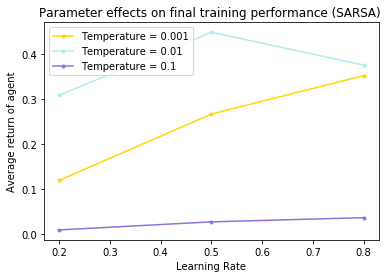

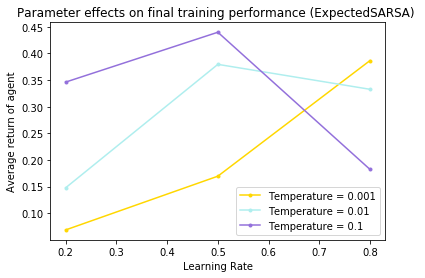

In [ ]:

plt.figure(1);
plt.plot(learning_rates, SARSA_training_results[:,0] , c= "gold", marker='.', linestyle='-');
plt.plot(learning_rates, SARSA_training_results[:,1] , c= "paleturquoise", marker='.', linestyle='-');
plt.plot(learning_rates, SARSA_training_results[:,2] , c= "mediumpurple", marker='.', linestyle='-');

plt.legend(['Temperature = 0.001', 'Temperature = 0.01', 'Temperature = 0.1']);
plt.ylabel("Average return of agent");
plt.xlabel("Learning Rate");
plt.title("Parameter effects on final training performance (SARSA) ");
plt.show();

plt.figure(2);
plt.plot(learning_rates, ExpectedSARSA_training_results[:,0] , c= "gold", marker='.', linestyle='-');
plt.plot(learning_rates, ExpectedSARSA_training_results[:,1] , c= "paleturquoise", marker='.', linestyle='-');
plt.plot(learning_rates, ExpectedSARSA_training_results[:,2] , c= "mediumpurple", marker='.', linestyle='-');

plt.legend(['Temperature = 0.001', 'Temperature = 0.01', 'Temperature = 0.1']);
plt.ylabel("Average return of agent");
plt.xlabel("Learning Rate");
plt.title("Parameter effects on final training performance (ExpectedSARSA) ");
plt.show();




*Question 1 b) parameter effects on final testing performance*

---



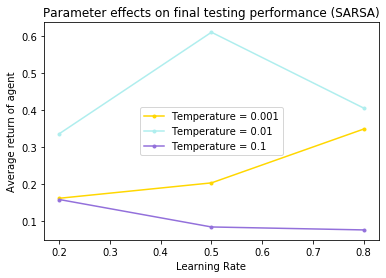

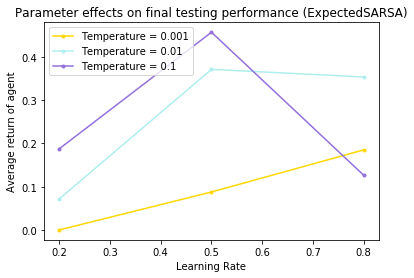

In [ ]:
plt.figure(3);
plt.plot(learning_rates, SARSA_testing_results[:,0] , c= "gold", marker='.', linestyle='-');
plt.plot(learning_rates, SARSA_testing_results[:,1] , c= "paleturquoise", marker='.', linestyle='-');
plt.plot(learning_rates, SARSA_testing_results[:,2] , c= "mediumpurple", marker='.', linestyle='-');

plt.legend(['Temperature = 0.001', 'Temperature = 0.01', 'Temperature = 0.1']);
plt.ylabel("Average return of agent");
plt.xlabel("Learning Rate");
plt.title("Parameter effects on final testing performance (SARSA)");
plt.show();

plt.figure(4);
plt.plot(learning_rates, ExpectedSARSA_testing_results[:,0] , c= "gold", marker='.', linestyle='-');
plt.plot(learning_rates, ExpectedSARSA_testing_results[:,1] , c= "paleturquoise", marker='.', linestyle='-');
plt.plot(learning_rates, ExpectedSARSA_testing_results[:,2] , c= "mediumpurple", marker='.', linestyle='-');

plt.legend(['Temperature = 0.001', 'Temperature = 0.01', 'Temperature = 0.1']);
plt.ylabel("Average return of agent");
plt.xlabel("Learning Rate");
plt.title("Parameter effects on final testing performance (ExpectedSARSA)");
plt.show();

*Question 1 C) parameter effects on final testing performance*

---



In [ ]:
best_learning_rate = 0.5;
best_temp = 0.01;


train, test, overall = run_SARSA_experiment(best_learning_rate,best_temp, env)

best_learning_rate = 0.5;
best_temp = 0.1;

train, test, overall2 = run_ExpectedSARSA_experiment(best_learning_rate,best_temp, env)



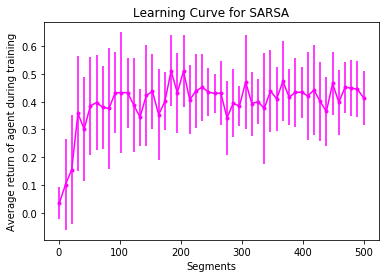

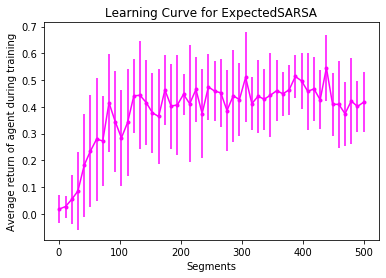

In [ ]:
plt.figure(5);
data = [];
err = [];
overall = np.array(overall)
for i in range(0,500,10): #plotted every 10 segments to avoid cluttering
  data.append(np.mean(overall[:,i]))
  err.append(np.std(overall[:,i]))

plt.errorbar(np.linspace(1, 500, 50), data, yerr=err, c= "magenta", marker='.', linestyle='-');
plt.title("Learning Curve for SARSA");
plt.ylabel("Average return of agent during training")
plt.xlabel("Segments")
plt.show();





plt.figure(6);
data = [];
err = [];
overall2 = np.array(overall2)
for i in range(0,500,10):
  data.append(np.mean(overall2[:,i]))
  err.append(np.std(overall2[:,i]))

plt.errorbar(np.linspace(1, 500, 50), data, yerr=err, c= "magenta", marker='.', linestyle='-');
plt.title("Learning Curve for ExpectedSARSA");
plt.ylabel("Average return of agent during training")
plt.xlabel("Segments")
plt.show();


**Discussion and Conclusion**

---

From these results, we observe comparable performance between SARSA and Expected SARSA. For the SARSA algorithm, intermediate temperature values (0.01) and intermediate learning rates (0.5) performed the best, with an average training return of 0.6 over 10 trials. In the Expected SARSA experiment, however, larger temperature values (0.1) performed better with intermediate learning rates (0.5). 

During testing, SARSA slightly outperformed Expected SARSA using intermediate hyper-parameter values. Additionally, it would seem that higher temperatures perform better with lower learning rates, and vice-versa (although further experimentation is required to confirm this). Expected SARSA performed slightly worse, however in both cases the best training hyper-parameters were also found to be the best testing hyper-parameters as well.

Upon observing the learning curves for both algorithms, we see that both algorithms learn at similar rates, with average return increasing dramatically within the first 100 segments, before plateauing around a return value of 0.4

Further study into the discount rate for this specific task is recommended, as well as a more refined hyper-parameter grid-search with additional computational resources. 

**COMP 579 Assignment 2 Q2**


---



The purpose of this experiment is to compare the Q_Learning and Actor-Critic algorithms utilizing linear function approximation when estimate Q-values. The experiment will be run using the [CartPole](https://https://gymnasium.farama.org/environments/classic_control/cart_pole/) benchmark RL task from the Gymnasium environment, where the aim of the experiment is to balance a poll on top of a cart by choosing to move the cart either left or right. The game ends when the poll falls over, or the cart leaves the designated boundary. 

In this experiment, the average discounted return of both algorithms is calculated from 10 independent runs, each consisting of 1000 episodes (plays of the game). Both algorithms use linear function approximation to update weights, which are then used to estimate action-values (Q-learning & Actor-Critic) as well as policy values (Actor Critic) during learning. Both algorithms have their weights initialized to random initial values between -0.001 and 0.001 between each independent run. 

In Q-Learning, the exploration policy is epsilon-greedy, with 3 values of ϵ being tested. For Actor-Critic, the chosen policy is softmax, with 3 values of temperature being tested. In the Actor-Critic implementation, the critic estimates the action-value of a particular state, rather than simply the state-value. This was an intentional choice, making both algorithms more similar in implementation, thus allowing us to attribute any difference to the actor-critic-specific aspect of the experiment. 

\

**Discretizing the CartPole state-space & Linear Function Approximation**


---

In order to implement linear function approximation, a discretization of the Cartpole state-space was performed. This was done using 4-hot encoding, where the each of the four environment observations (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) were first placed into 10 bins depending on their values (0- corresponding to the lowest observed value during experiments, and 9- corresponding to the highest observed value). These bin values were then encoded into an array of dimension 4x10, where the i-th column of the j-th row is 1 if the j-th observation value falls into bin i. This array was then flattened, and served as the state features for a particular observation. To allow for (state,action) features, this array was doubled (dimensions now 1x80) to allow the algorithms to distinguish between states when choosing to move left and states when choosing to move right. This meant that each state had a feature array consisting of 80 features in total, with 40 features for each action. 

As such, linear function approximation was performed using 80 weights for Q-Learning, and 160 weights for Actor-Critic (80 for q-value estimation, and 80 for policy estimation). 

Below is the implementation of the Q-Learning Class. 



In [ ]:
class Q_Learning:

  def __init__(self, learning_rate, gamma, epsilon, environment, seed=1234):
    self.learning_rate=learning_rate
    self.epsilon=epsilon
    self.environment = environment
    self.gamma = gamma
    self.weights = np.zeros((80)) 
    self.seed = seed

    #randomly initialize weights according to seed
    np.random.seed(self.seed)

    for i in range(self.weights.size): 
      self.weights[i] = random.uniform(-0.001, 0.001)

 
  def discretized_observation(self, observation):
    #discretize uniformly into 10 bins based on valid feature ranges
    CART_RANGE = 2.4
    CART_VEL_RANGE = 3.0
    POLE_ANGLE_RANGE = 0.2095
    POLE_VEL_RANGE = 6.0
    num_bins = 10


    d_observation = [np.floor((observation[0]/CART_RANGE*(num_bins/2) + num_bins/2)), 
                     np.floor((observation[1]/CART_VEL_RANGE*(num_bins/2) + num_bins/2)),
                     np.floor((observation[2]/POLE_ANGLE_RANGE*(num_bins/2) + num_bins/2)),
                     np.floor((observation[3]/POLE_VEL_RANGE*(num_bins/2) + num_bins/2))]

    for i in range (len(d_observation)):
      if d_observation[i] > 9.0:
        d_observation[i] = 9.0
      elif d_observation[i] < 0.0:
        d_observation[i] = 0.0

    return d_observation

   #acts as a wrapper for env.step(action), returns an encoded array corresponding to a state in the discretized state-space, as well as other information about the environment 
  def discretized_step(self, action):
    observation, reward, terminated, truncated, info =  self.environment.step(action)


    d_observation = self.discretized_observation(observation)
    
    return d_observation, reward, terminated, truncated, info


  def get_features(self, state, action):
    
    features = np.zeros((8,10))
    #print(state)
    for i in range(4):
      
      features[(action+1)*i, int(state[i])] = 1 #encode feature array of 80 features

    return features.flatten()


    
  def choose_from_e_greedy_policy(self, state):
    if np.random.random() < self.epsilon:
      return np.random.choice([0,1]) #randomly choose to go left or right
    else:
      if(self.get_q_value(state, 0) > self.get_q_value(state,1)):
        return 0
      else:
        return 1

  def get_q_value(self, state, action):
    features = self.get_features(state, action)

    return np.dot(self.weights, features)

  def get_max_q_value(self, state):

    v1 = self.get_q_value(state, 0)
    v2 = self.get_q_value(state, 1)
    
    if v1 > v2:
      return v1
    else:
      return v2
      

  def learn(self, state, action, reward, state2):
    #Weight update equation
    target = reward + self.gamma * self.get_max_q_value(state2)
    self.weights += self.learning_rate * (target - self.get_q_value(state, action)) * self.get_features(state, action)


  #runs an episode, returns the return of the episode
  def run_episode(self):

    return_after_episode = 0
    episode_length = 0

    #initialize
    observation, info = self.environment.reset()
    state1 = self.discretized_observation(observation)

    action1 = self.choose_from_e_greedy_policy(state1)
    state2, reward, terminated, truncated, info = self.discretized_step(action1)

    self.learn(state1,action1,reward,state2)

    state1 = state2

    #compute return for 1 episode step
    return_after_episode += reward*pow(self.gamma,episode_length)
    episode_length += 1


    #continue until end of episode
    while(not terminated and not truncated): 

      action1 = self.choose_from_e_greedy_policy(state1)
      state2, reward, terminated, truncated, info = self.discretized_step(action1)

      self.learn(state1,action1,reward,state2)
      state1 = state2
    
      #compute return for remaining episode steps
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1
    return return_after_episode

**Q-Learning Experiment Set-up**


---



In [ ]:

env = gym.make('CartPole-v1')
env.reset()
testQ = Q_Learning(0.2, 1.0, 0.1, env)

def run_Q_Learning_experiment(learning_rate, epsilon, environment):
  independent_runs = [];
  last_testing_return = [];
  seeds=[0,1,2,3,4,5,6,7,8,9]

  for j in range(10):#10 independent runs
  
    testQ = Q_Learning(learning_rate, 0.99, epsilon, environment, seed=seeds[j])
    reward_per_episode = []
    for i in range(1000): #Each run is 500 segments
      return_value = testQ.run_episode()
      reward_per_episode.append(return_value)
    
    independent_runs.append(reward_per_episode)
  
  independent_runs = np.array(independent_runs)

  mean_return = [];
  std_err = [];
  for i in range(1000):
    mean_return.append(np.mean(independent_runs[:,i]))
    std_err.append(np.std(independent_runs[:,i]))


  return mean_return, std_err #gives return averaged over last 10 training episodes and the 10 independent runs




**Q-Learning Hyper-parameters**


---

For the Q-Learning experiment, a range of hyper-parameter values for both the learning rate α and ϵ were tested. As instructed an initial search of α = 1/4, 1/8, 1/6 was conducted, however initial experiments found the algorithm to perform poorly, with learning stagnant and average raturns fluctating around 20. Thus, lower values of α (0.02, 0.015, 0.01) were tested, and were found to dramatically increase the learning curves for all values of ϵ.

For ϵ, previous experiments (not shown) found that lower values around the 0.1 range performed best. Thus a slightly more refined grid-search within the range of 0.1 was conducted for this experiment. Below we see the results of these hyper-parameter combinations. 

For both Q-Learning and Actor-Critic, a discount rate of 0.99 was used, in order to minimally penalize future rewards. 

**Q-Learning Results**


---



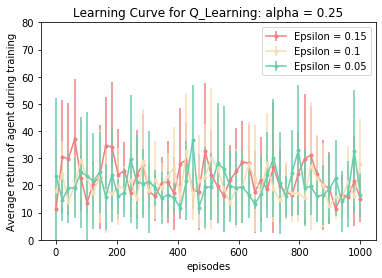

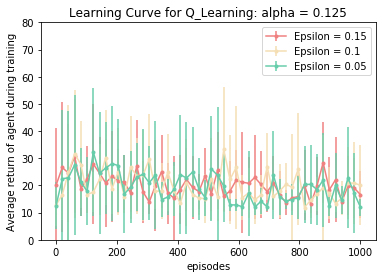

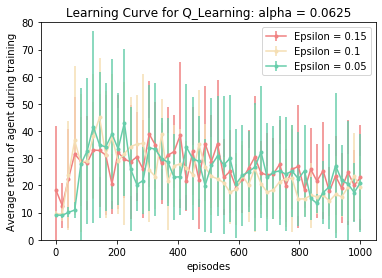

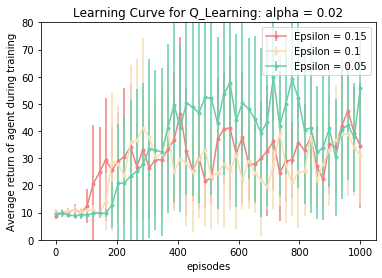

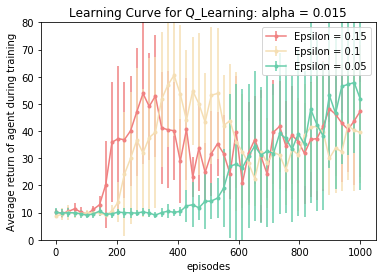

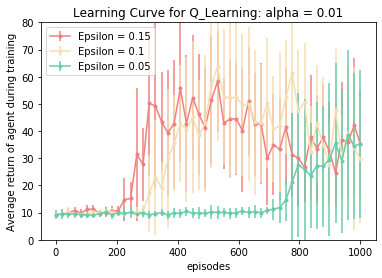

In [ ]:
learning_rates = [0.25, 0.125, 0.0625, 0.02, 0.015, 0.01]
epsilons = [0.15, 0.1, 0.05]
colours = ["lightcoral", "wheat", "mediumaquamarine"]

for k in range(len(learning_rates)):
  plt.figure(k)
  for j in range(len(epsilons)):
    data, err = run_Q_Learning_experiment(learning_rates[k], epsilons[j], env)
    modified_data = [];
    modified_err = [];
    for i in range(1, 1000, 20):
      modified_data.append(data[i])
      modified_err.append(err[i])

    plt.errorbar(np.linspace(1, 1000, 50), modified_data, yerr=modified_err, c= colours[j], marker='.', linestyle='-'); 
  plt.title("Learning Curve for Q_Learning: alpha = " + str(learning_rates[k]));
  plt.ylabel("Average return of agent during training")
  plt.xlabel("episodes")
  plt.legend( ["Epsilon = " + str(epsilons[t]) for t in range(len(epsilons))])
  plt.ylim([0,80])
  plt.show();
  #Note that only every 20th data point was plotted in order to make the graphs legible.

**Q-Learning Discussion of Results**


---

As can be seen, for higher values of α, the algorithm performs poorly, fluctuating around an average return of 20 points per episode. As α decreases, we observe a sharp increase in return for all values of ϵ, strongly suggesting that values in the range of α = 0.015 perform well for this task. However, we observe that for most values of ϵ in this range, average return increases sharply to around 50 points, before fluctuating and decreasing. Furthermore, standard deviation for these values is high, suggesting that the algorithm has difficult converging to the optimal policy. This effect is somewhat reduced for lower values of ϵ (0.05), however these results suggest that the algorithm is unable to converge to the optimal policy after reaching a score of roughly 50 points per episode. 


**Actor-Critic Implementation**


---



In [ ]:
class Actor_Critic:

  def __init__(self, learning_rate, gamma, temperature, environment, seed=1234):
    self.learning_rate=learning_rate
    self.temperature=temperature
    self.environment = environment
    self.gamma = gamma
    self.actor_weights = np.zeros((80)) 
    self.critic_weights = np.zeros((80))
    self.seed = seed

    #randomly initialize weights according to seed
    np.random.seed(self.seed)

    for i in range(self.actor_weights.size): 
      self.actor_weights[i] = random.uniform(-0.001, 0.001)
      self.critic_weights[i] = random.uniform(-0.001, 0.001)

 
  def discretized_observation(self, observation):
    #discretize uniformly into 10 bins based on valid feature ranges
    CART_RANGE = 2.4
    CART_VEL_RANGE = 3.0
    POLE_ANGLE_RANGE = 0.2095
    POLE_VEL_RANGE = 6.0
    num_bins = 10


    d_observation = [np.floor((observation[0]/CART_RANGE*(num_bins/2) + num_bins/2)), 
                     np.floor((observation[1]/CART_VEL_RANGE*(num_bins/2) + num_bins/2)),
                     np.floor((observation[2]/POLE_ANGLE_RANGE*(num_bins/2) + num_bins/2)),
                     np.floor((observation[3]/POLE_VEL_RANGE*(num_bins/2) + num_bins/2))]

    for i in range (len(d_observation)):
      if d_observation[i] > 9.0:
        d_observation[i] = 9.0
      elif d_observation[i] < 0.0:
        d_observation[i] = 0.0

    return d_observation

   #acts as a wrapper for env.step(action), returns an encoded array corresponding to a state in the discretized state-space, as well as other information about the environment 
  def discretized_step(self, action):
    observation, reward, terminated, truncated, info =  self.environment.step(action)


    d_observation = self.discretized_observation(observation)
    
    return d_observation, reward, terminated, truncated, info


  def get_features(self, state, action):
    
    features = np.zeros((8,10))
    #print(state)
    for i in range(4):
      
      features[(action+1)*i, int(state[i])] = 1 #encode feature array of 80 features

    return features.flatten()


    
  def choose_from_softmax_policy(self, state):
    softmax_prob_array = [];
    #get probabilities for each action
    prob_sum = np.exp(self.get_policy_value(state,0)/self.temperature) + np.exp(self.get_policy_value(state,1)/self.temperature)

    #boltzmann equation
    for i in range(2):
     
      probability = np.exp(self.get_policy_value(state,i)/self.temperature)/prob_sum
      if(np.isnan(probability)):
        #if the probability is NaN, this means that the denominator is infinite, and so numerator must also be inf
        #so replace with probability = 1
        probability = 1.0
     
      softmax_prob_array.append(probability); #stores probability of action i at index i. 
    #print(softmax_prob_array)
    return np.random.choice([0,1], p=softmax_prob_array), softmax_prob_array

  def get_q_value(self, state, action):
    features = self.get_features(state, action)

    return np.dot(self.critic_weights, features)

  def get_policy_value(self, state, action):
    features = self.get_features(state, action)

    return np.dot(self.actor_weights, features)



  def update_policy_weights(self, state, action, reward):
    #Weight update equation
    probabilities = self.choose_from_softmax_policy(state)[1]
    expectation = probabilities[0]*self.get_features(state, 0) + probabilities[1]*self.get_features(state, 1)
    gradient = self.get_features(state, action) - expectation
    self.actor_weights += self.learning_rate*self.get_q_value(state, action)*gradient

      

  def learn(self, state, action, reward, state2, action2):
    #Weight update equation
    delta = reward + self.gamma * self.get_q_value(state2, action2) - self.get_q_value(state, action)
    self.critic_weights += self.learning_rate * delta * self.get_features(state, action)


  #runs an episode, returns the return of the episode
  def run_episode(self):

    return_after_episode = 0
    episode_length = 0

    #initialize
    observation, info = self.environment.reset()
    state1 = self.discretized_observation(observation)

    action1 = self.choose_from_softmax_policy(state1)[0]
    state2, reward, terminated, truncated, info = self.discretized_step(action1)
    action2 = self.choose_from_softmax_policy(state2)[0]

    self.update_policy_weights(state1, action1, reward)

    self.learn(state1,action1,reward,state2,action2)

    state1 = state2
    action1 = action2

    #compute return for 1 episode step
    return_after_episode += reward*pow(self.gamma,episode_length)
    episode_length += 1


    #continue until end of episode
    while(not terminated and not truncated): 

      action1 = self.choose_from_softmax_policy(state1)[0]
      state2, reward, terminated, truncated, info = self.discretized_step(action1)
      action2 = self.choose_from_softmax_policy(state2)[0]

      self.update_policy_weights(state1, action1, reward)
      self.learn(state1,action1,reward,state2, action2)

      state1 = state2
      action1 = action2
      #compute return for remaining episode steps
      return_after_episode += reward*pow(self.gamma,episode_length)
      episode_length += 1
    return return_after_episode

**Actor-Critic Experiment Set-up**


---



In [ ]:
env = gym.make('CartPole-v1')
env.reset()

def run_actor_critic_experiment(learning_rate, temperature, environment):
  independent_runs = [];
  last_testing_return = [];
  seeds=[0,1,2,3,4,5,6,7,8,9]

  for j in range(10):#10 independent runs
  
    testAC = Actor_Critic(learning_rate, 0.99, 1, environment, seed=seeds[j])
    reward_per_episode = []
    for i in range(1000): #Each run is 1000 episodes
      return_value = testAC.run_episode()
      reward_per_episode.append(return_value)
    
    independent_runs.append(reward_per_episode)
  
  independent_runs = np.array(independent_runs)

  mean_return = [];
  std_err = [];
  for i in range(1000):
    mean_return.append(np.mean(independent_runs[:,i]))
    std_err.append(np.std(independent_runs[:,i]))


  return mean_return, std_err #gives return averaged over last 10 training episodes and the 10 independent runs

**Actor-Critic Hyper-parameters**

Similar to Q-Learning, the Actor-Critic algorithm was tested using α = 1/4, 1/8, 1/16. Like Q-Learning, the algorithm performed poorly using these initial values, and so lower α values were experimented with, (α = 0.02, 0.015, 0.01). Since the policy for Actor-Critic was Softmax, we also included a range of temperature values to test. These values were taken over a broad range (temperature = 10, 1, 0.1) to give an initial sense of which range of values worked well for this specific task. For simplicity, both the Actor and Critic used the same learning rate α.

For both Q-Learning and Actor-Critic, a discount rate of 0.99 was used in order to minimally penalize future rewards. 


**Actor-Critic Results**


---



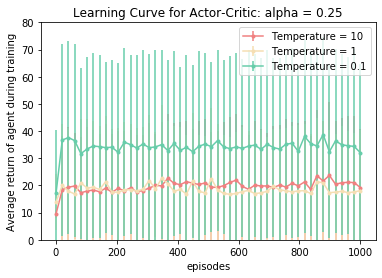

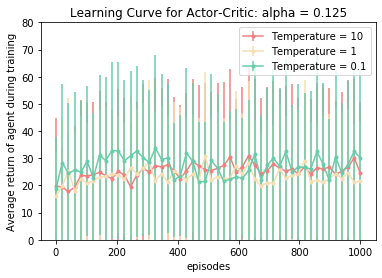

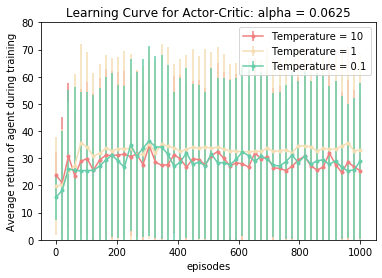

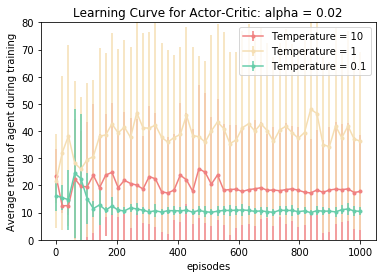

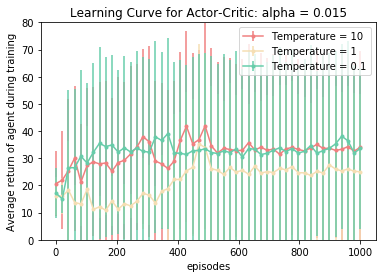

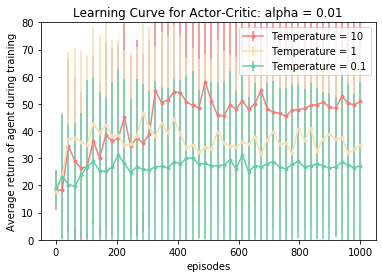

In [ ]:
learning_rates = [0.25, 0.125, 0.0625, 0.02, 0.015, 0.01]
temperatures = [10, 1, 0.1]
colours = ["lightcoral", "wheat", "mediumaquamarine"]

for k in range(len(learning_rates)):
  plt.figure(k)
  for j in range(len(temperatures)):
    data, err = run_actor_critic_experiment(learning_rates[k], temperatures[j], env)
    modified_data = [];
    modified_err = [];
    for i in range(1, 1000, 20):
      modified_data.append(data[i])
      modified_err.append(err[i])

    plt.errorbar(np.linspace(1, 1000, 50), modified_data, yerr=modified_err, c= colours[j], marker='.', linestyle='-');
  plt.title("Learning Curve for Actor-Critic: alpha = " + str(learning_rates[k]));
  plt.ylabel("Average return of agent during training")
  plt.xlabel("episodes")
  plt.legend( ["Temperature = " + str(temperatures[t]) for t in range(len(temperatures))])
  plt.ylim([0,80])
  plt.show();

**Actor-Critic Discussion of Results**


---

Similar to Q-Learning, for higher values of α, the Actor-Critic algorithm performs poorly, fluctuating around an average return of 30 points and failing to learn an effective policy. Despite this, Actor-Critic returns for these values seemed to perform comparably or better than the equivalent  hyper-parameters used for Q-learning. Likewise, as α decreases, we see the algorithm begin to learn policies which generate an average return of around 40 points. Initial results suggest that higher learning rates perform better with lower values for temperature (and vice versa) for this task, however more experiments would be required for this generalization to be conclusive. Unlike Q-Learning, once an average return of roughly 50 is reached, the algorithm seems to stabilize around that value, suggesting that the limitation in learning is due to the function approximation rather than the model itself. Nevertheless, in both cases, the algorithm fails to consistently achieve an average return above 50 points. 

**Actor Critic vs. Q-Learning on CartPole task**


---





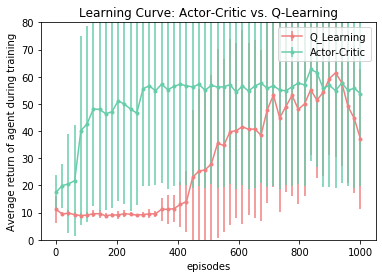

In [ ]:

temperatures = [10, 1, 0.1]
colours = ["lightcoral", "wheat", "mediumaquamarine"]

plt.figure(20) #Plot best Q-Learning hyperparameters
data, err = run_Q_Learning_experiment( 0.015, 0.05, env)
modified_data = [];
modified_err = [];
for i in range(1, 1000, 20):
    modified_data.append(data[i])
    modified_err.append(err[i])

plt.errorbar(np.linspace(1, 1000, 50), modified_data, yerr=modified_err, c= "lightcoral", marker='.', linestyle='-');


 #Plot best Actor-Critic hyperparameters
data, err = run_actor_critic_experiment( 0.01, 10, env)
modified_data = [];
modified_err = [];
for i in range(1, 1000, 20):
  modified_data.append(data[i])
  modified_err.append(err[i])

plt.errorbar(np.linspace(1, 1000, 50), modified_data, yerr=modified_err, c= "mediumaquamarine", marker='.', linestyle='-');


plt.title("Learning Curve: Actor-Critic vs. Q-Learning" );
plt.ylabel("Average return of agent during training")
plt.xlabel("episodes")
plt.legend( ["Q_Learning", "Actor-Critic"])
plt.ylim([0,80])
plt.show();

**Discussion and Conclusion**


---
From the previous results, we found that the best hyper-parameters were as follows:
\
\
*Q_Learning: α=0.015, ϵ=0.05*
\
\
*Actor_Critic: α=0.01, temperature=10*
\
\
These values were selected based on highest average return over 1000 episodes, as well as how much the average return fluctuated over the episodes (some hyper-parameters performed well early on, but achieved lower returns as the episodes progressed)


When comparing the performance of Actor-Critic and Q-Learning for the CartPole task, we observe that Actor-Critic reaches a supposed optimal policy (average return of 50 per episode) faster than Q-Learning, with a smoother and more stable learning curve. Comparatively, Q-Learning's learning curve was far more erratic, requiring lower learning rates to achieve stability in learning. Q-Learning was slower to reach an average return of 50 points per episode, and its performance drops off considerably in the last few episodes, suggesting an inability to converge to an optimal policy. As such, these experiments suggest that Actor-Critic is better suited to solving the CartPole task with linear function approximation. 
\
Interestingly, however, is that both algorithms managed to consistently reach an average return of 50 points per episode with at least one hyper-parameter combination, yet neither algorithm managed to exceed this figure. This suggests that the main limitation to learning the CartPole task is not hyper-parameter selection, but rather the implmentation of linear function approximation. A possible area of further study would be to discretize the environment observations into more bins, or perhaps to discretize the bins in such a way that values distributed closer to the mean observations are more likely to be separated into different bins. This would allow us to refine the state-space, with the hope of creating more effective features. 

